In [3]:
import random
import imageio
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.12.0


# Подготовка датасета
 Загружаем оригинальный MNIST (train и test) и приводим данные у удобному формату:
  * размер: (N, 28, 28, 1), где N - количество образцов в подвыборке
  * значения интенсивности: float32 в диапазоне [0, 1]
    

In [5]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

 # Визуализация нескольких образцов из MNIST

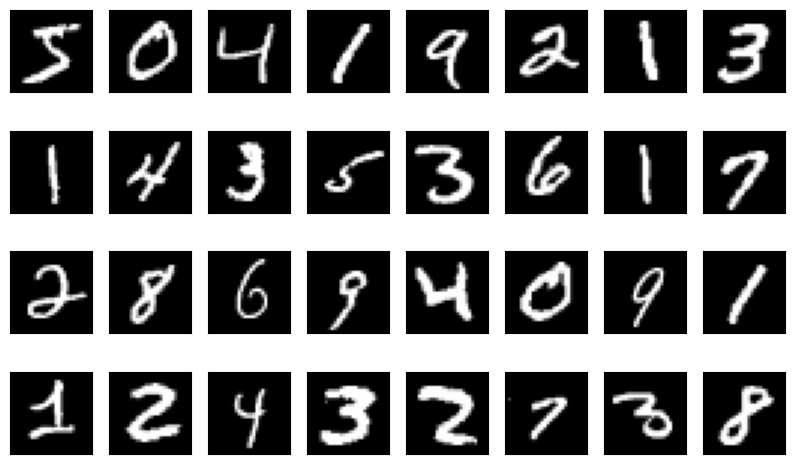

In [6]:
def plot_some_samples(some_samples):
    fig = plt.figure(figsize=(10, 6))
    for j in range(some_samples.shape[0]):
        ax = fig.add_subplot(4, 8, j+1)
        ax.imshow(some_samples[j, :, :, 0], cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_some_samples(train_x[:32, ...])

**Аугментация: добавление образцов класса "фон"**
Для задач локализации нам необходимо добавить дополнительный класс "фон", который обозначает "отсутствие цифры". Индекс этого 11-го класса
будет "10" (классы нумеруются с 0)

Однако, недостаточно просто взять черную картинку и использовать её как образец фона. Если в скользящее окно попадет небольшой кусочек 
цифры, это тоже должно означать отсутствие цифры.

Сгенерируем соотвествующие образцы из образцов MNIST со случайным смещением по координатам X и Y в диапазоне [25%, 75%].
Так как при таком подходе у нас будут автоматически получаться абсолютно чёрные картинки (где цифра после сдвига ушла за пределы картинки) 
нам не нужно отдельно генерировать чисто черные картинки для класса "фон".

Затем визуализируем несколько образцов.

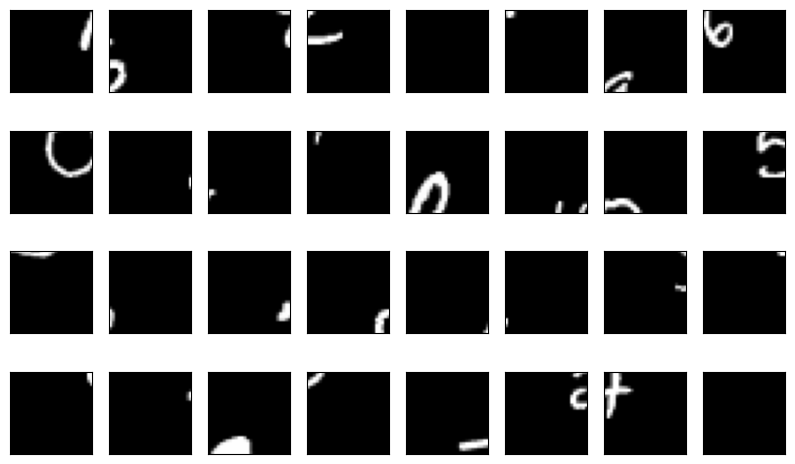

In [9]:
bg_samples = 100000 # Количество обучающих образцов из класса "фон"
bg_train_x = np.zeros((bg_samples, 28, 28, 1), dtype=np.float32)
bg_train_y = np.zeros((bg_samples,), dtype=np.int32) * 10

src_idxs = random.choices(range(train_x.shape[0]), k=bg_samples)

sh = train_x.shape[1]
sw = train_x.shape[2]
for i in range(bg_samples):
    dh = random.randint(sh//4, 3*sh//4) * random.choice([-1, 1])
    dw = random.randint(sw//4, 3*sw//4) * random.choice([-1, 1])
    
    sample = train_x[src_idxs[i], ...]
    
    bg_train_x[i, max(-dh, 0):min(sh-dh, sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max(dh, 0):min(sh+dh, sh), max(dw, 0):min(sw+dw, sw), :]

plot_some_samples(bg_train_x[:32, ...])

# **Аугментация: добавление образцов исходных классов цифр**
Для более наглядной локализации необходимо так же добавить образцы с незначительными смещениями. Если цифра не строго по центру, но всё
равно попала в окно, значит это окно надо классифицировать как цифру.
Сгенерируем соответствующие образцы из образцов MNIST со случайным смещением по координатам X и Y в диапазоне [0, 25%].
Затем визуализируем несколько образцов.

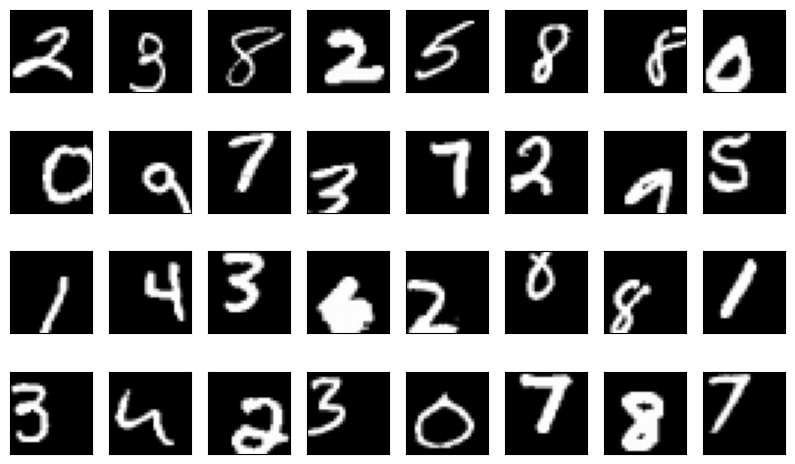

In [10]:
sh_samples = 50000 # Количесво дополнительно сгенерированных цифр со смещениями

sh_train_x = np.zeros((sh_samples, 28, 28, 1), dtype=np.float32)
sh_train_y = np.zeros((sh_samples,), dtype=np.int32)

src_idxs = random.sample(range(train_x.shape[0]), sh_samples)

sh = train_x.shape[1]
sw = train_x.shape[2]
for i in range(sh_samples):
    dh = random.randint(0, sh//4) * random.choice([-1, 1])
    dw = random.randint(0, sw//4) * random.choice([-1, 1])
    
    sample = train_x[src_idxs[i], ...]
    
    sh_train_x[i, max(-dh, 0):min(sh-dh, sh), max(-dw, 0):min(sw-dw, sw), :] = \
        sample[max(dh, 0):min(sh+dh, sh), max(dw, 0):min(sw+dw, sw), :]
    sh_train_y[i] = train_y[src_idxs[i]]
    
plot_some_samples(sh_train_x[:32, ...])

# Объединение исходного датасета MNIST и двух новых сгенерированных
Получаем финальные train и test датасеты, содержащие исходные и новые сгенерированные данные (конкатенируем всё по нулевому измерению)

In [12]:
train_x = np.concatenate((train_x, bg_train_x, sh_train_x), axis=0)
train_y = np.concatenate((train_y, bg_train_y, sh_train_y), axis=0)

# Обучение классификатора

Для начала нам необходимо обучить обычный классификатор для распознавания цифр, но на нашем новом аугментированном датасете с классом
"фон". Далее мы будем применять этот классификатор для задачи слабой локализации.

# Параметры обучения

In [13]:
NUM_CLASSES = 11
NUM_EPOCHS = 3
BATCH_SIZE = 64

# Классификационная модель
Это наш классификатор на основе CNN. На выходе 11 классов.

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Подготовка модели к обучению

In [17]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

# Обучение модели

In [20]:
from livelossplot.tf_keras import PlotLossesCallback

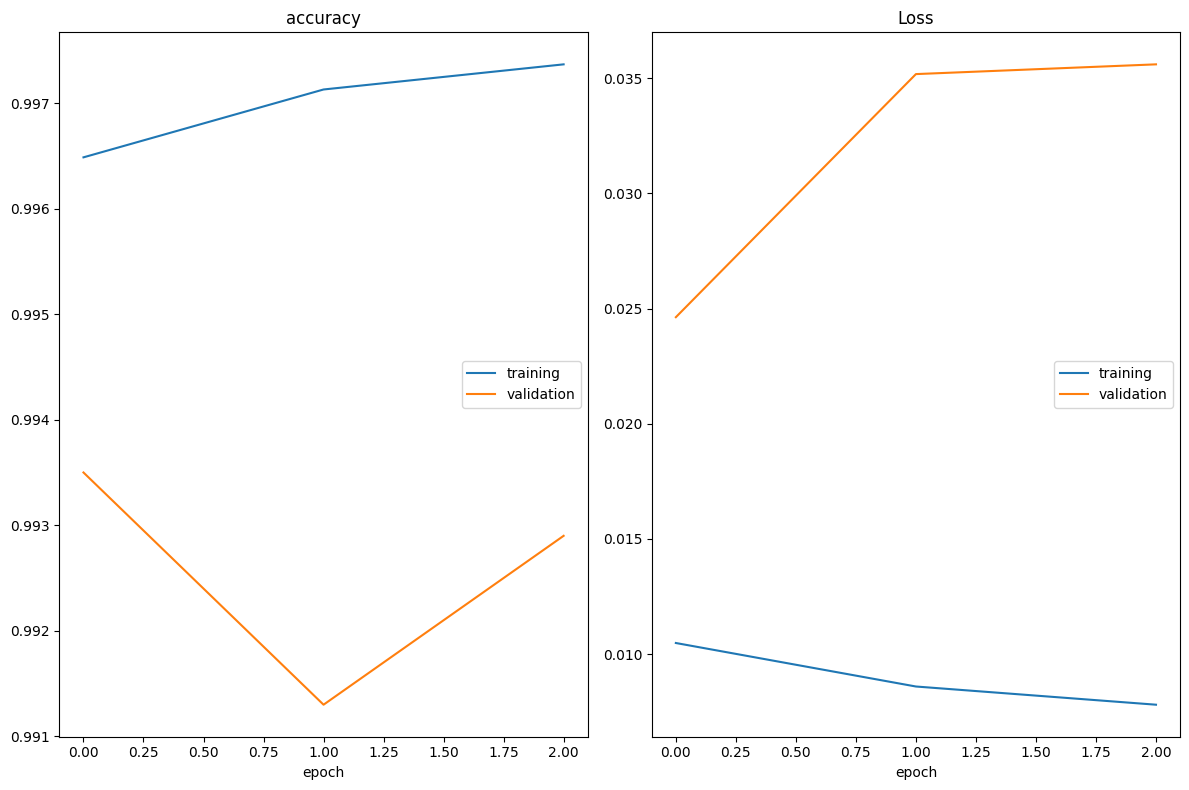

accuracy
	training         	 (min:    0.996, max:    0.997, cur:    0.997)
	validation       	 (min:    0.991, max:    0.993, cur:    0.993)
Loss
	training         	 (min:    0.008, max:    0.010, cur:    0.008)
	validation       	 (min:    0.025, max:    0.036, cur:    0.036)
3282/3282 [==============================] - 33s 10ms/step - loss: 0.0078 - accuracy: 0.9974 - val_loss: 0.0356 - val_accuracy: 0.9929


In [22]:
model.fit(train_x, train_y, 
          epochs=NUM_EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(test_x, test_y),
          callbacks=[PlotLossesCallback()])

# Оценка качества модели

In [23]:
model.evaluate(test_x, test_y)

313/313 [==============================] - 1s 4ms/step - loss: 0.0356 - accuracy: 0.9929


[0.03559999167919159, 0.992900013923645]